In [1]:
import glob

import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib
import matplotlib.animation
import matplotlib.pyplot as plt

from invisible_cities.database.load_db       import DataSiPM
from invisible_cities.io      .pmap_io       import load_pmaps
from invisible_cities.reco    .xy_algorithms import barycenter
from invisible_cities.reco    .xy_algorithms import corona
from invisible_cities.types   .ic_types_c    import minmax

from invisible_cities.icaro.hst_functions import labels

%matplotlib inline

plt.rcParams["figure.figsize"] = 12, 8
plt.rcParams[  "font.size"   ] = 15

In [2]:
filenames = glob.glob("/Users/Gonzalo/github/NEXTdata/Th/4735/*.h5")
pmaps = {}
for filename in filenames:
    *_, si = load_pmaps(filename)
    print(filename, "contains", len(si), "events")
    pmaps.update(si)

evt_nos = np.array(list(pmaps))

print("Total number of events:", len(evt_nos))

/Users/Gonzalo/github/NEXTdata/Th/4735/pmaps_000_4735_icdev_20171006_th_th2000.h5 contains 110 events
/Users/Gonzalo/github/NEXTdata/Th/4735/pmaps_001_4735_icdev_20171006_th_th2000.h5 contains 110 events
/Users/Gonzalo/github/NEXTdata/Th/4735/pmaps_002_4735_icdev_20171006_th_th2000.h5 contains 112 events
/Users/Gonzalo/github/NEXTdata/Th/4735/pmaps_003_4735_icdev_20171006_th_th2000.h5 contains 111 events
/Users/Gonzalo/github/NEXTdata/Th/4735/pmaps_004_4735_icdev_20171006_th_th2000.h5 contains 112 events
/Users/Gonzalo/github/NEXTdata/Th/4735/pmaps_005_4735_icdev_20171006_th_th2000.h5 contains 112 events
/Users/Gonzalo/github/NEXTdata/Th/4735/pmaps_006_4735_icdev_20171006_th_th2000.h5 contains 111 events
/Users/Gonzalo/github/NEXTdata/Th/4735/pmaps_007_4735_icdev_20171006_th_th2000.h5 contains 112 events
/Users/Gonzalo/github/NEXTdata/Th/4735/pmaps_008_4735_icdev_20171006_th_th2000.h5 contains 111 events
/Users/Gonzalo/github/NEXTdata/Th/4735/pmaps_009_4735_icdev_20171006_th_th2000.h5 

In [3]:
datasipm = DataSiPM(4735)

In [4]:
def plot_tracking(si, thr=-float("inf")):
    si = si.s2sid
    f = plt.figure()
    for peak_no, peak in si.items():
        (sipm_ids,
         sipm_qs ) = zip(*peak.items())
        sipm_ids   =     list(sipm_ids)
        sipm_qs    = np.array(sipm_qs)
        sipm_xs    = datasipm.X.values[sipm_ids]
        sipm_ys    = datasipm.Y.values[sipm_ids]
        for slice_no, qs in enumerate(sipm_qs.T):
            plt.clf()
            sel = qs >= thr
            sc = plt.scatter(sipm_xs[sel],
                             sipm_ys[sel],
                             c = qs [sel],
                             marker = "s")
            plt.xlim(np.min(sipm_xs), np.max(sipm_xs))
            plt.ylim(np.min(sipm_ys), np.max(sipm_ys))
            plt.colorbar(sc).set_label("SiPM charge (pes)")
            labels("x (mm)", "y (mm)", f"Peak #{peak_no} Slice #{slice_no}")
            plt.show()

def relative_distance(x0, y0, x, y):
    return np.sqrt((x - x0)**2 +
                   (y - y0)**2 )

def compute_qdr(si):
    si = si.s2sid
    
    drs    = []
    Qs     = []
    Qnorms = []
    Qmax   = []
    for peak_no, peak in si.items():
        (sipm_ids,
         sipm_qs ) = zip(*peak.items())
        sipm_ids   =     list(sipm_ids)
        sipm_qs    = np.array(sipm_qs)
        sipm_xs    = datasipm.X.values[sipm_ids]
        sipm_ys    = datasipm.Y.values[sipm_ids]
        for slice_no, qs in enumerate(sipm_qs.T):
            index_max = np.argmax(qs)
            x_max = sipm_xs[index_max]
            y_max = sipm_ys[index_max]
            dr    = relative_distance(x_max, y_max, sipm_xs, sipm_ys)
            drs   .extend(dr)
            Qs    .extend(qs)
            Qnorms.extend(qs/np.max(qs))
            Qmax  .append((peak_no, slice_no, np.max(qs)))
    return drs, Qs, Qnorms, Qmax

In [ ]:
DRs, Qs, Qnorms, Qmaxs = [], [], [], []
for evt_no in evt_nos:
    list(map(list.extend, [DRs, Qs, Qnorms, Qmaxs], compute_qdr(pmaps[evt_no])))
DRs, Qs, Qnorms, Qmaxs = map(np.array, [DRs, Qs, Qnorms, Qmaxs])

In [ ]:
plt.scatter(drs, qnorms)
labels("Relative transverse distance to the hottest SiPM (mm)", "$Q_sipm/Q_max$")

In [ ]:
plt.scatter(drs, qs)
labels("Relative transverse distance to the hottest SiPM (mm)", "$Q_sipm$")

In [ ]:
plt.hist(Qmaxs[:, 2], 200)
#plt.xscale("log")
labels("Hottest SiPM charge (pes)", "Entries")

In [97]:
def define_xy_window(x, y, min_size = 0):
    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)
    dx = xmax - xmin
    dy = ymax - ymin
    if dx < min_size:
        xmean = np.mean([xmin, xmax])
        xmin  = xmean - min_size/2
        xmax  = xmean + min_size/2

    if dy < min_size:
        ymean = np.mean([ymin, ymax])
        ymin  = ymean - min_size/2
        ymax  = ymean + min_size/2

    return minmax(xmin, xmax), minmax(ymin, ymax)

In [149]:
def make_movie(X, Y, Z, Q,
               thr = 0, absolute_thr = True,
               absolute_qscale = True,
               min_size = 50):
    """
    X: np.ndarray, shape = (nsipm,)
        x coordinate of each sipm with signal at some point
    Y: np.ndarray, shape = (nsipm,)
        y coordinate of each sipm with signal at some point
    Z: np.ndarray, shape = (nslices,)
        z coordinate of each slice
    Q: np.ndarray, shape = (nslices, nsipm)
        charge for each sipm for all slices
    thr: float, optional
        threshold to all sipms (see absolute_thr). Defaults
        to 0.
    absolute_thr: bool, optional
        if True (default), the threshold is applied to all
        slices in the same way with the same value. If False
        the threshold value is relative to the charge of the
        hottest sipm.
    absolute_qscale: bool, optional
        Whether to adjust the charge range in each slice to
        the maximum of each slice (false) or to the maximum
        of all slices (true, default).
    min_size: float, optional
        Minium size of the xy-plane window displayed. This is
        to avoid small events to be in a misleading scale.
        Default is 50.
    """
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6)
    
    xrange, yrange = define_xy_window(X, Y, min_size)
    zs = sorted(list(set(Z)))

    def init():
        global cbar, scplot
        labels("x (mm)", "y (mm)")
        ax.set_xlim(*xrange)
        ax.set_ylim(*yrange)
        scplot = ax.scatter([], [], c=[])
        cbar = fig.colorbar(scplot, ax=ax)
        cbar.set_label("Charge (pes)")
        return (scplot,)

    def animate(i):
        global cbar, scplot
        selection = Z == zs[i]
        x, y, q = X, Y, Q[i]
        selection = Q[i] > thr * (1 if absolute_thr else np.max(Q[i]))
        x, y, q = X[selection], Y[selection], Q[i, selection]
        cbar.remove()
        fig.clear()
        ax = plt.gca()
        labels("x (mm)", "y (mm)")
        ax.set_xlim(*xrange)
        ax.set_ylim(*yrange)

        vmax = np.max(Q) if absolute_qscale else (np.max(q) if np.any(q) else 1)
        scplot = ax.scatter(x, y, c=q, marker="s", vmin=0, vmax=vmax)
        cbar = fig.colorbar(scplot, ax=ax, boundaries=np.linspace(0, vmax, 100))
        cbar.set_label("Charge (pes)")
        return (scplot,)

    anim = matplotlib.animation.FuncAnimation(fig, animate, init_func=init,
                                              frames=len(zs), interval=200,
                                              blit=False)
    return anim

In [150]:
evt        = pmaps[2]
peak       = evt.s2sid[0]
(sipm_ids,
sipm_qs )  = zip(*peak.items())
sipm_ids   =     list(sipm_ids)
sipm_qs    = np.array(sipm_qs).T
sipm_xs    = datasipm.X.values[sipm_ids]
sipm_ys    = datasipm.Y.values[sipm_ids]
sipm_zs    = np.arange(len(sipm_qs))

In [151]:
sipm_xs.shape, sipm_ys.shape, sipm_zs.shape, sipm_qs.shape

((885,), (885,), (50,), (50, 885))

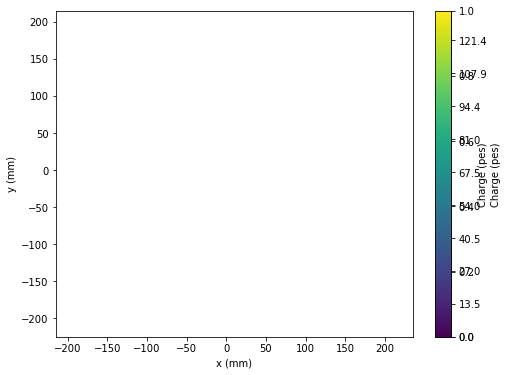

In [153]:
%matplotlib inline
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

matplotlib.rc('animation', html='html5')
make_movie(sipm_xs, sipm_ys, sipm_zs, sipm_qs, thr=5)
#make_movie(sipm_xs, sipm_ys, sipm_zs, sipm_qs, thr=5, absolute_qscale=False)
#make_movie(sipm_xs, sipm_ys, sipm_zs, sipm_qs, thr=0.1, absolute_thr=False)